In [1]:
%load_ext jupyter_black

import notebooks_path

notebooks_path.include_packages()
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import functools
import tqdm

from vit import dataloader, util, model, train

In [2]:
batch_size = 8

In [3]:
train_dataloader = dataloader.get_train_dataloader(batch_size)
test_dataloder = dataloader.get_test_dataloader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image = next(iter(test_dataloder))

In [5]:
jax_image = jnp.array(image[0][0].numpy())
print(jax_image.shape)

(3, 32, 32)


In [6]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

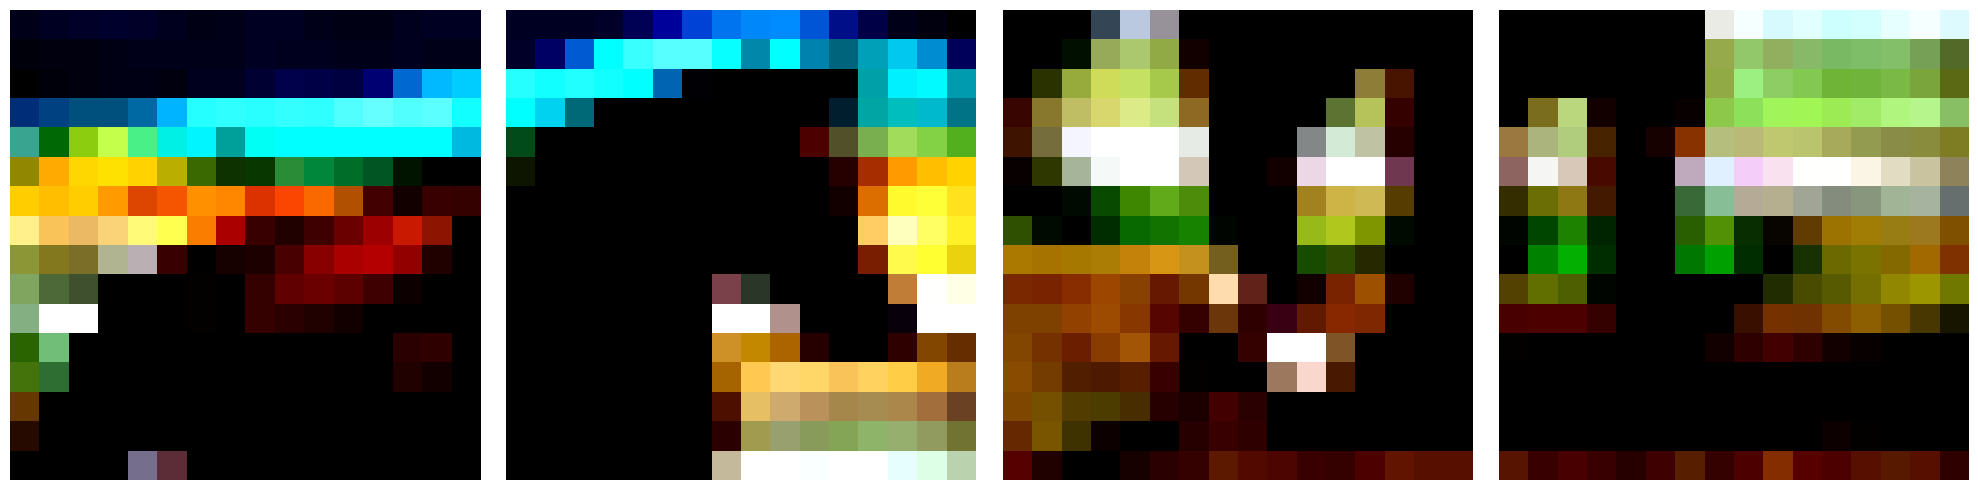

In [7]:
util.plot_patches(patches)

In [8]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

In [9]:
# Hyperparameters
lr = 0.0001
dropout_rate = 0.1
beta1 = 0.9
beta2 = 0.999
patch_size = 4
num_patches = 64
num_steps = 100000
image_size = (32, 32, 3)
embedding_dim = 512
hidden_dim = 256
num_heads = 8
num_layers = 6
height, width, channels = image_size
num_classes = 10

In [10]:
key = jr.PRNGKey(2003)

model_obj = model.VisionTransformer(
    embedding_dim=embedding_dim,
    channels=channels,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    patch_size=patch_size,
    num_patches=num_patches,
    num_classes=num_classes,
    key=key,
)

optimizer = optax.adamw(
    learning_rate=lr,
    b1=beta1,
    b2=beta2,
)

state = optimizer.init(eqx.filter(model_obj, eqx.is_inexact_array))

model_obj, state, losses = train.train(
    model_obj, optimizer, state, train_dataloader, batch_size, num_steps, key=key
)

> /teamspace/studios/this_studio/mlp-playground/playground/vit/model.py(83)__call__()
     81 
     82         import pdb; pdb.set_trace()
---> 83         input_x = jax.vmap(self.layer_norm2)(x)
     84         input_x = jax.vmap(self.linear1)(input_x)
     85         input_x = jax.nn.gelu(input_x)

(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
(65, 512)
> /teamspace/studios/this_studio/mlp-playground/playground/vit/model.py(83)__call__()
     81 
     82         import pdb; pdb.set_trace()
---> 83         input_x = jax.vmap(self.layer_norm2)(x)
     84         input_x = jax.vmap(self.linear1)(input_x)
     85         input_x = jax.nn.gelu(input_x)

> /teamspace/studios/this_studio/mlp-playground/playground/vit/model.py(83)__call__()
     81 
     82         import pdb; pdb.set_trace()
---> 83         input_x = jax.vmap(self.layer_norm2)(x)
     84         input_x = jax.vmap(self.lin

In [ ]:
accuracies = []

for batch in range(len(test_dataloder.dataset) // batch_size):
    images, labels = next(iter(test_dataloder))

    logits = jax.vmap(functools.partial(model_obj, enable_dropout=False))(
        images.numpy(), key=jax.random.split(key, num=batch_size)
    )

    predictions = jnp.argmax(logits, axis=-1)

    accuracy = jnp.mean(predictions == labels.numpy())

    accuracies.append(accuracy)

print(f"Accuracy: {jnp.sum(jnp.array(accuracies)) / len(accuracies) * 100}%")

Accuracy: 81.89000701904297%
